<a href="https://colab.research.google.com/github/Inno732/Data-Mining-Project-Jerome-Inno/blob/main/Active_Learning_Lab_Omega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
!rm -rf sample_data

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#%cd drive/My\ Drive/MYPATH
%cd drive/My Drive/Dataset colab

/content/drive/My Drive/Dataset colab


#1. Active learning with Binary classification

In [5]:
pts = []
with open('XYtrain.dat') as fin:

    for i in range(100):
        x,y,z = fin.readline().replace('\n', '').split()

        pts.append([float(x), float(y), int(z)])

test_pts = []
with open('XYtest.dat') as fin:

    for i in range(100):
        x,y,z = fin.readline().replace('\n', '').split()

        test_pts.append([float(x), float(y), int(z)])


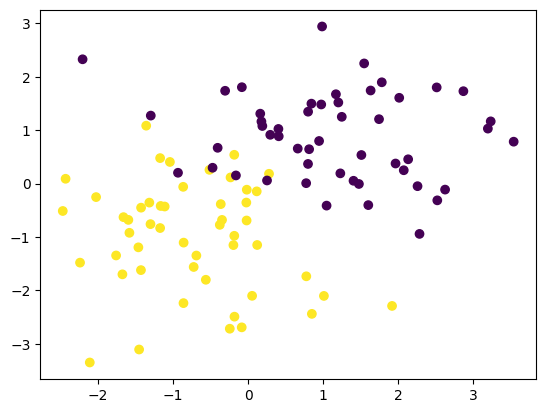

In [6]:
x = [pts[i][0] for i in range(len(pts))]
y = [pts[i][1] for i in range(len(pts))]
z = [pts[i][2] for i in range(len(pts))]

plt.scatter(x, y, c = z)
plt.show()

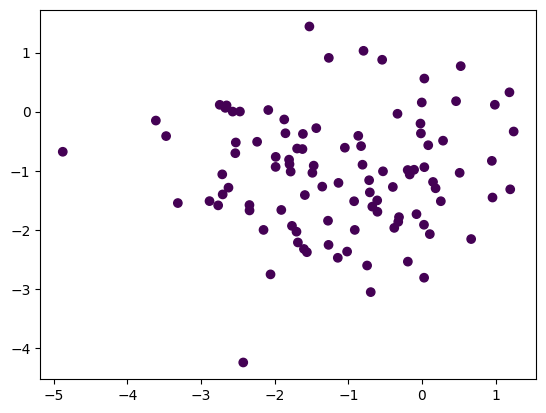

In [7]:
test_x = [test_pts[i][0] for i in range(len(test_pts))]
test_y = [test_pts[i][1] for i in range(len(test_pts))]
test_z = [test_pts[i][2] for i in range(len(test_pts))]

plt.scatter(test_x, test_y, c = test_z)
plt.show()

**2 - Build a kNN classifier on the whole data set, with k = 7 and Measure the resulting test score.**

In [15]:
# This fct return the accuracy * 100 and Knn model

def knn(train_point, test_point):
  model = KNeighborsClassifier(n_neighbors=7)

  #trainning set
  xy = [[pi[0], pi[1]] for pi in train_point]
  z = [pi[2] for pi in train_point]

  #train the model using trainning set
  model.fit(xy, z)

  # test set
  test_xy = [[pi[0], pi[1]] for pi in  test_point]
  z_test = [pi[2] for pi in test_point]

  # evaluate the model on the test set
  pred = model.predict(test_xy)
  accuracy = accuracy_score(z_test, pred)
  #print("the accuracy is" , accuracy*100)

  return accuracy * 100, model


In [18]:
acc, model_1 = knn(pts, test_pts)
print(acc)

92.0


3. Instead of using the whole data set, randomly select n = 10 samples and train the kNN classifier, with k = 7, on these n = 10 samples. Measure the resulting test score. Because the training set is composed of random samples, multiple executions will result in distinct outputs. Repeat the execution multiple times (at least 50 times) and average the outputs. Compare the averaged scores with those obtained when training on the whole data set and comment the result.

In [10]:
a,_ = knn(pts, test_pts)

In [26]:
import random
import statistics
acc_random = statistics.mean([ knn(random.choices(pts, k = 10), test_pts)[0] for i in range(50)])
acc_random

# acc_random = np.mean([knn(random.choices(pts, k = 10), test_pts)[0] for i in range(50)])

65.14

On the whole data, the test score obtained is 92 and when we randomly select n=10 samples, the resulting score is 64.14.

4. Make another initial training set in a deterministic way by selecting the first 8 samples from class 0 and the first 2 samples from class 1. Train the kNN on this initial training set and record the test score. By progressively adding new randomly selected samples (passive learning), vary n from 10 to 60 (i.e. n ∈ {10, 11, 12, ..., 60}). For each value of n, train the kNN classifier with k = 7 and measure the test score. Plot the test score with respect to n.


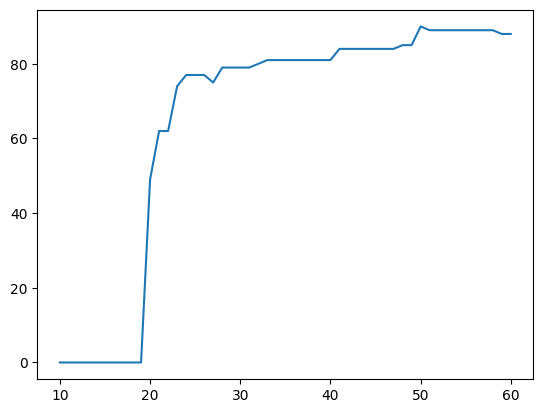

In [62]:
passive_0 = []

# take the 10 first data points
n0 = 0
n1 = 1
pts_used = []
pts_left = []
for pi in pts:
  if pi[2] == 0 and n0 < 8:
    pts_used.append(pi)
    n0 += 1
  elif pi[2] == 1 and n1 < 2:
    pts_used.append(pi)
    n1 += 1
  else:
    pts_left.append(pi)

# new randomly selected samples
random.shuffle(pts_left)

for i in range(51):
  ac,_ = knn(pts_used, test_pts)
  passive_0.append(ac)
  pts_used.append(pts_left.pop(0))

mean_passive_0 = statistics.mean(passive_0)

# Plot the test score with respect to n
x_vals = range(10, 61)
plt.plot(x_vals, passive_0)

5. Because passive learning is essentially random, the plot obtained at the previous question varies from one execution to another. Repeat the execution multiple times (at least 50 times) and average the test scores for each n. Plot the averaged test score and its standard deviation according to the training set size.
**Remark**: It is important that the initial training set remains the same from one execution to another

In [51]:
passive = [[] for i in range(51)]

for it in range(50):
  # take the 10 first data points
  n0 = 0
  n1 = 1
  pts_used = []
  pts_left = []
  for pi in pts:
    if pi[2] == 0 and n0 < 8:
      pts_used.append(pi)
      n0 += 1
    elif pi[2] == 1 and n1 < 2:
      pts_used.append(pi)
      n1 += 1
    else:
      pts_left.append(pi)
  # new randomly selected samples
  random.shuffle(pts_left)

  for i in range(51):
    ac,_ = knn(pts_used, test_pts)
    passive[i].append(ac)
    pts_used.append(pts_left.pop(0))

mean_passive = [statistics.mean(pi) for pi in passive]

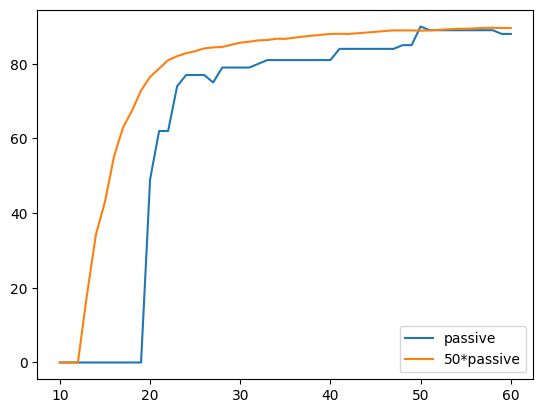

In [68]:
#  Plot the test scores and compare
x_vals = range(10, 61)
plt.plot(x_vals, passive_0)
plt.plot(x_vals, mean_passive)
plt.legend(['passive', '50*passive'], loc='lower right')
plt.show()

6. Instead of randomly adding new samples, use the active learning method to progressively select new training samples. The size of the training set still varies from 10 to 60 by steps of 1. Plot the test scores and compare with the results obtained previously.
Is active learning useful ?

In [79]:
active = []

for it in range(50):
  # take the 10 first data points
  n0 = 0
  n1 = 1
  pts_used = []
  pts_left = []
  for pi in pts:
    if pi[2] == 0 and n0 < 8:
      pts_used.append(pi)
      n0 += 1
    elif pi[2] == 1 and n1 < 2:
      pts_used.append(pi)
      n1 += 1
    else:
      pts_left.append(pi)

# new randomly selected samples
random.shuffle(pts_left)

for i in range(51):
  if i == 0:
    acc, model = knn(pts_used, test_pts)
    active.append(acc)
    continue

  # active learning method to progressively select new training samples
  pos_best_point = 0
  proba_best_point = 1

  prob = model.predict_proba([[pi[0], pi[1]] for pi in pts_left])

  for count, pro in enumerate(prob):
    if max(pro[0], pro[1]) <= proba_best_point:
      pos_best_point = count
      proba_best_point = max(pro[0], pro[1])

  pts_used.append(pts_left.pop(pos_best_point))
  acc, model = knn(pts_used, test_pts)

  active.append(acc)

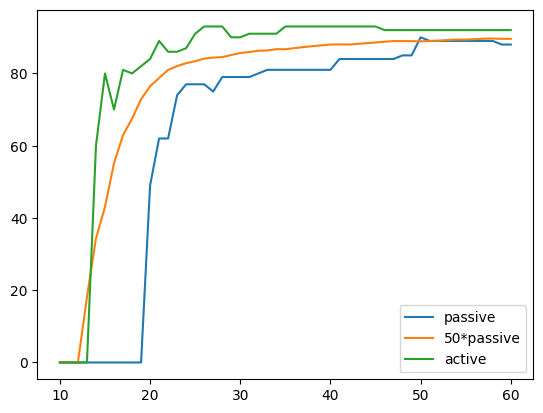

In [80]:
#  Plot the test scores and compare
x_vals = range(10, 61)
plt.plot(x_vals, passive_0)
plt.plot(x_vals, mean_passive)
plt.plot(x_vals, active)
plt.legend(['passive', '50*passive', 'active'], loc='lower right')
plt.show()

#2. Active learning with 3-classes classification